## 1. 80,000 Chicago taxi trips

Let's do some data explorations!

### Objectives

- Exploring Chicago Taxi Trips Data. 
- Find key Insigts on chicago trips such as Trends
- Identify the peak hours during day versus weekly and monthly trends. The can help plan for better organizing and reduce traffic congestions!
- Look at the availibility hours of drivers and get insights on some KPI's

## Table of contents:
* Loading Data and Initialization
* Histogram of Fares
* Visualizing start of the joureny
* Finding the peak time of day
* Longer routes (Do people rely more on public transport for longer commutes)
* Trend number or rides per week
* Is driving a cab a luxury job? Do we see more revenues and more drivers trend?
* Correlation between fare and tip
* Driver captain analysis
    * Get the drivers schedule 
    * Top performing drivers per quarter
    * Visulazing Occupancy to highlight hours where there's availibility

In [69]:
# Loading lidyverse
library(tidyverse)
library(bigrquery)
library(data.table)
library(lubridate)
library(viridis)

# Load Enviroment Variables
readRenviron('.Renviron')
projectID = Sys.getenv('BIGQUERY_PROJECT_ID')

Loading required package: viridisLite


## Loading Data

#### The dataset is from loaded from the public dataset provided by Google in BigQuery. 
##### Dataset has the following columns
- Unique key : Unique identifier for the trip.
- Taxi ID: A unique identifier for the taxi.
- Trip Start Time Stamp: Rounded to the nearest 15 mins
- Trip End Time: Rounded to the nearest 15 mins
- Trip Seconds: Time of the trip in seconds
- Trip Miles: Distance taken by trip in miles
- Pickup Cencus Tract: The Census Tract where the trip began. For privacy, this Census Tract is not shown for some trips.
- DropOff Cencus Tract: The Census Tract where the trip ended. For privacy, this Census Tract is not shown for some trips.
- Pickup Community: Community Area where the trip began
- DropOff Community: Drop off Area where thr trip ended
- Fare: The fare of the trip
- Tips: Tips provided. Cash tips will not be provided
- Tolls: Tolls for the trip
- Extra: Extra charges for the trip
- Trip Total: Total Cost of the trip
- Payment Type: Type of the payment 
- Company: Taxi Company
- Pickup Latitude: Pickup Latitude
- Pickup Longitude: Pickup Logitude
- Dropoff Latitude: Drop Off Latitude
- Dropoff Longitude: Dropoff Longitude

In [18]:
# Loading Data 
# taxi <- list.files(pattern = "*.csv", path="./data", 
# full.names=TRUE) %>% map_df(~read_csv(., col_types = cols(
#   .default = col_character(),
#   trip_seconds = col_integer(),
#   trip_miles = col_double(),
#   pickup_community_area = col_integer(),
#   dropoff_community_area = col_integer(),
#   fare = col_double(),
#   tips = col_double(),
#   tolls = col_double(),
#   extras = col_double(),
#   trip_total = col_double(),
#   pickup_latitude = col_double(),
#   pickup_longitude = col_double(),
#   dropoff_latitude = col_double(),
#   dropoff_longitude = col_double()
# )))
# head(taxi)


taxi_base <- fread('./dataset/base.csv', 
        select = c(
            "trip_start_timestamp", 
            "trip_end_timestamp", 
            "trip_seconds", 
            "trip_miles",
            "fare",
            "tips",
            "trip_total",
            "pickup_latitude",
            "pickup_longitude",
            "dropoff_latitude",
            "dropoff_longitude"
        )
)


### Inspect Data

- Display the first few rows
- Print the number of records

In [8]:
head(taxi_base)
nrow(taxi_base)

trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,trip_total,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2017-03-15 17:15:00 UTC,2017-03-15 17:15:00 UTC,305,0.8,5.75,0.0,5.75,41.87401,-87.66352,41.87401,-87.66352
2017-03-15 17:15:00 UTC,2017-03-15 17:45:00 UTC,1260,1.6,11.25,0.0,14.25,41.88099,-87.63275,41.89092,-87.61887
2017-03-15 17:15:00 UTC,2017-03-15 17:30:00 UTC,540,1.0,7.00,0.0,7.00,41.88099,-87.63275,41.89207,-87.62887
2017-03-15 17:15:00 UTC,2017-03-15 17:15:00 UTC,480,0.4,6.00,3.0,9.50,41.88099,-87.63275,41.88099,-87.63275
2017-03-15 17:15:00 UTC,2017-03-15 18:00:00 UTC,3015,12.8,35.50,7.1,42.60,41.88499,-87.62099,41.78600,-87.75093
2017-03-15 17:15:00 UTC,2017-03-15 17:30:00 UTC,840,1.4,8.75,0.0,8.75,41.88099,-87.63275,41.89833,-87.62076


[1] 6243978

### That's about 6 million records!

In [9]:
# Filter out empty columns and values

taxi <- taxi_base %>% filter(!is.na(trip_start_timestamp) | trip_start_timestamp != "") %>% filter(trip_total > 0 )

# Select certain columns taxi_id, trip_seconds, trip_miles, fare, trip_total, trip_start_timestamp, trip_end_timestamp,pickup_latitude, pickup_longitude

# Calculate the variance, min, and maximum fare
min(taxi$trip_total)
max(taxi$trip_total)
var(taxi$trip_total)


[1] 0.01

[1] 9826.37

[1] 1356.755

### Histogram of the fares

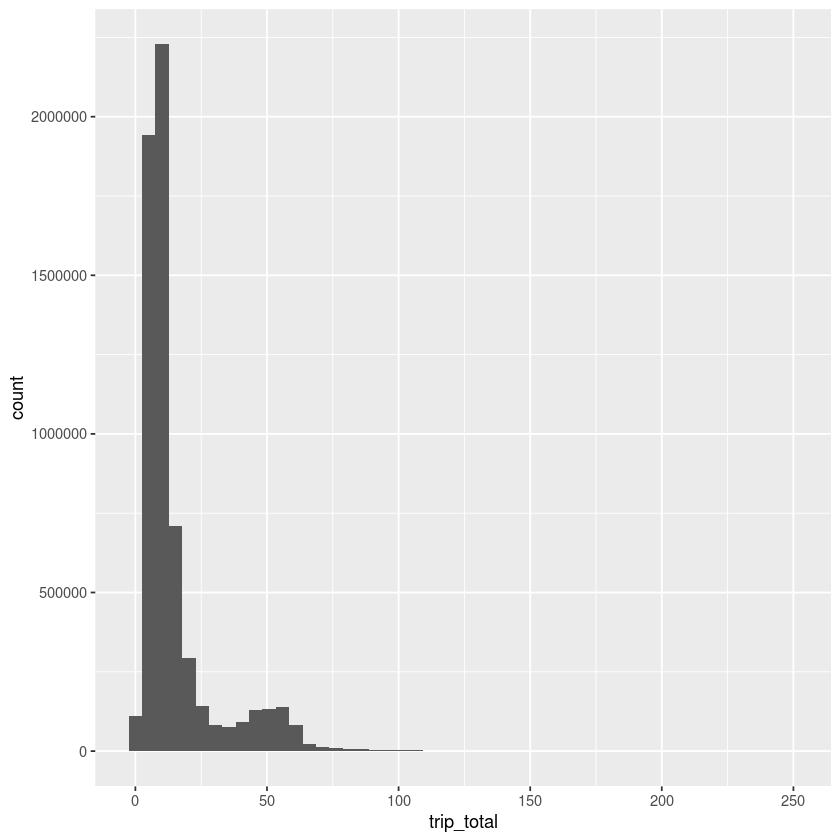

In [10]:
ggplot(taxi %>% filter(trip_total < 250), aes(x=trip_total)) + geom_histogram(bins=50)

In [11]:
# There is huge varaince between min and maximum fares .. A good trick to remedy the effect of outliers is to use the logarithmic of logs
taxi <- taxi %>% mutate(trip_total_logarithmic=log(trip_total))

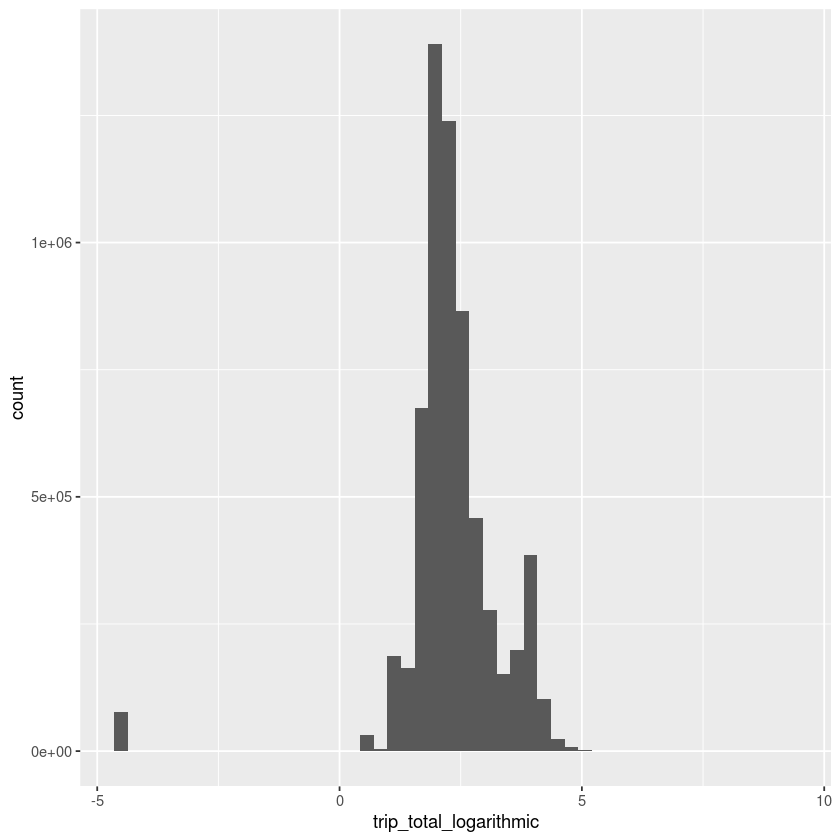

In [12]:
ggplot(taxi, aes(x=trip_total_logarithmic)) + geom_histogram(bins=50)

### Visualizing the begining of the journey

In [13]:
library(ggmap)
library(viridis)
#chicago <- get_map("chicago", zoom = 10, color = "bw")

chicago <- readRDS("data/chicago.rds")


Google's Terms of Service: https://cloud.google.com/maps-platform/terms/.
Please cite ggmap if you use it! See citation("ggmap") for details.
Loading required package: viridisLite


In [14]:
# Saving the RDS for future use 
saveRDS(chicago, file = "./data/chicago.rds")


Warning message:
“Removed 608463 rows containing non-finite values (stat_bin2d).”

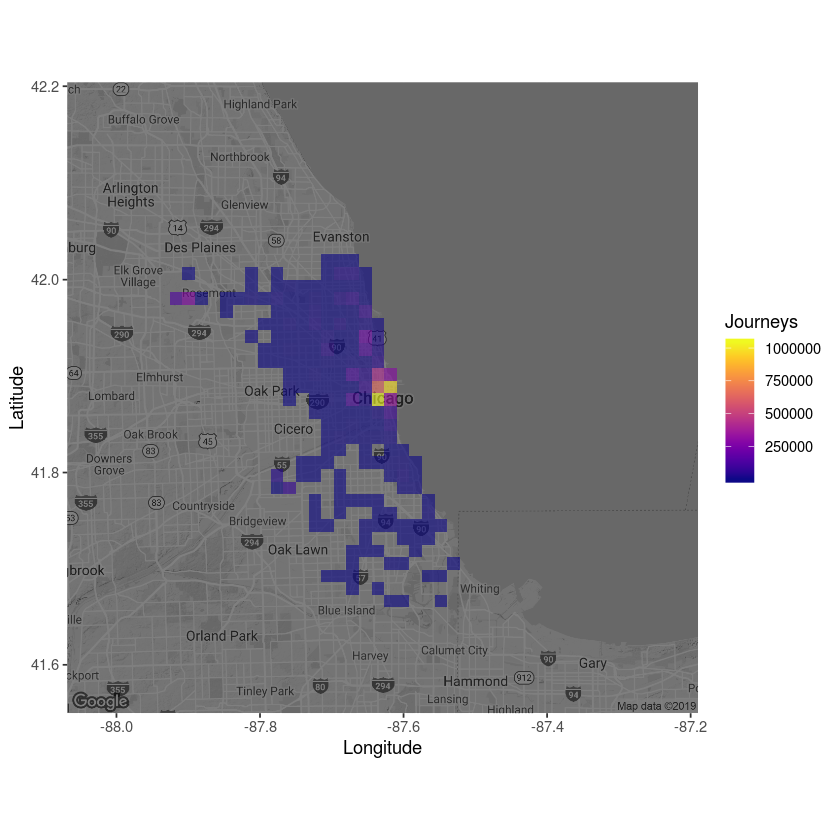

In [15]:

# Drawing a density map with the number of journey start locations
ggmap(chicago, darken = 0.5) +
   scale_fill_viridis(option = 'plasma') +
   geom_bin2d(data = taxi, aes(x=pickup_longitude, y=pickup_latitude), bins=50, alpha = 0.6) + labs(x='Longitude', y='Latitude', fill='Journeys')


### Breaking the datetime into week of day, month, and time

In [16]:
library('lubridate')


taxi <- taxi %>% mutate(
    trip_start_wkday=wday(trip_start_timestamp, label=TRUE, abbr=FALSE, locale = Sys.getlocale("LC_TIME")),
    trip_start_month=month(trip_start_timestamp, TRUE),
    trip_start_year=year(trip_start_timestamp),
    trip_start_week=strftime(trip_start_timestamp, format = "%W"),
    trip_start_dayofyear=yday(trip_start_timestamp),
    trip_start_time_hour=strftime(trip_start_timestamp, format = "%H")
    
)



Attaching package: ‘lubridate’

The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following object is masked from ‘package:base’:

    date



### Peak Time of day
#### Let's find the time of day where there are high demands of vehicles. 

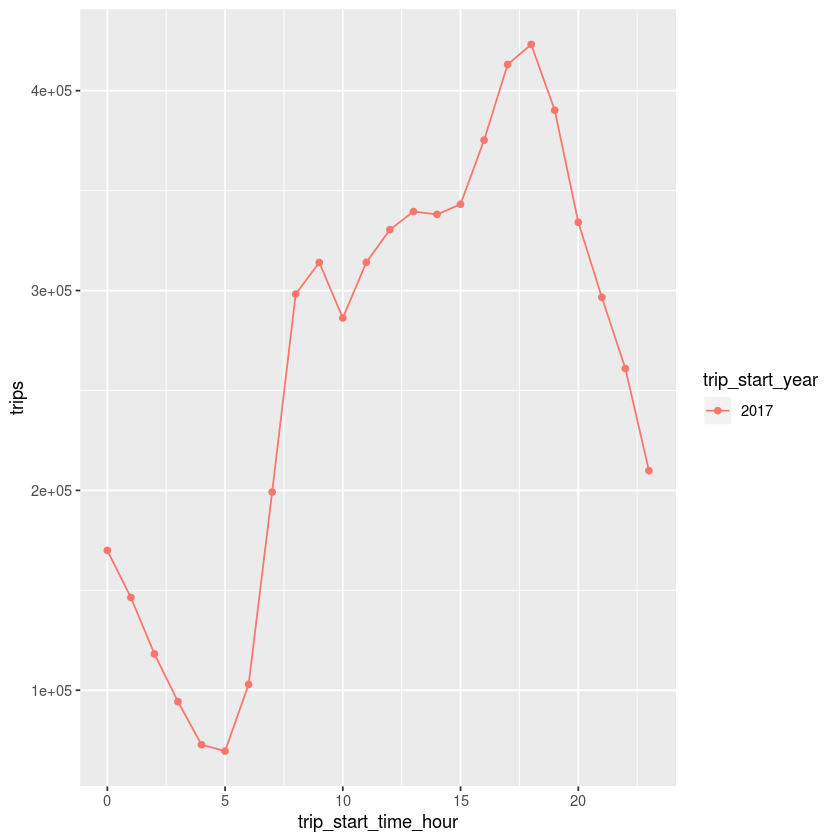

In [17]:
taxi_peak_time_of_day <- taxi %>% group_by(trip_start_year, trip_start_time_hour) %>% summarize(trips =n())
taxi_peak_time_of_day <-  taxi_peak_time_of_day %>% transform(trip_start_time_hour = as.numeric(trip_start_time_hour), trip_start_year=as.character(trip_start_year))
ggplot(taxi_peak_time_of_day, aes(x=trip_start_time_hour, y=trips, color=trip_start_year)) +  geom_point() + geom_line()


#### Let's find the time of day across all data. 
##### The following dataset was prepared by running the following query on BigQuery.

SELECT FORMAT_TIMESTAMP('%Y', `trip_start_timestamp`) AS trip_start_year, FORMAT_TIMESTAMP('%H', `trip_start_timestamp`) AS trip_start_time_hour, count(*) AS trips FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` group by trip_start_year, trip_start_time_hour order by trip_start_year DESC, trip_start_time_hour ASC

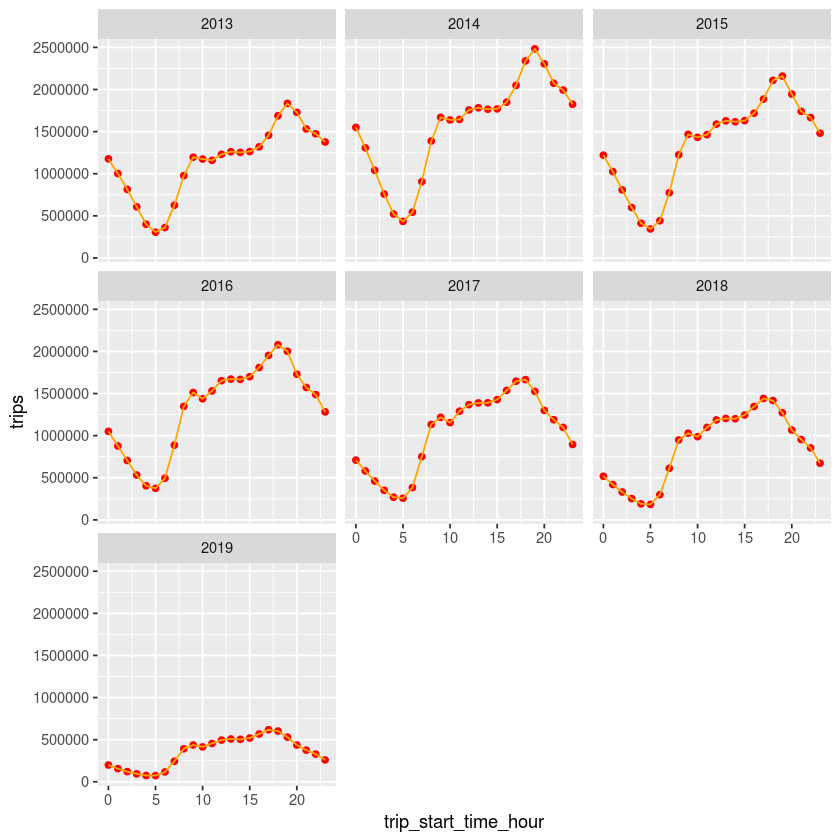

In [104]:
no_trips_summary_group_by_year_and_hour <- fread('dataset/no_trips_summary_group_by_year_and_hour.csv');
ggplot(no_trips_summary_group_by_year_and_hour, aes(x=trip_start_time_hour, y=trips)) +  geom_point(color="red") + geom_line(color="orange") + facet_wrap(~ trip_start_year)

#### The graph shows the number of rides (y-axis) and trip start time (x-axis) for the years 2013 to 2019. 
The peak times from 3 pm to 8 pm.

###  Longer routes..  

Trip miles can be used as indicator for passengers relying on public transports for longer distance journey's. Let's explore the the number of rides accross month. We will define a longe route as = 2 * average trip mile


numeric(0)

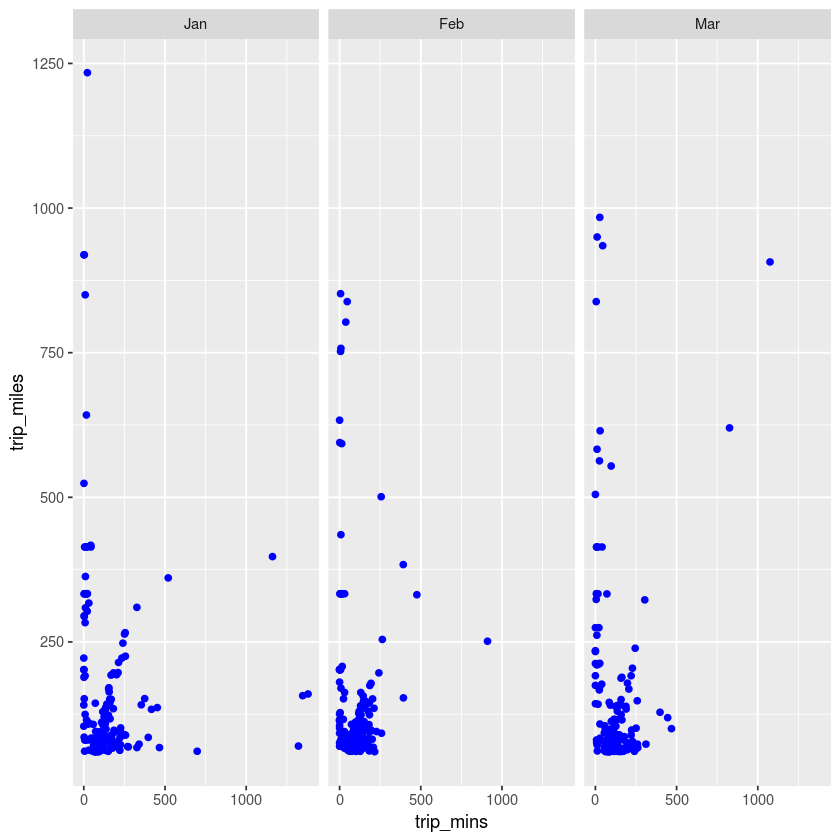

In [105]:
long_route_threshold <- lapply(taxi[,'trip_miles'],mean, na.rm = TRUE)
long_route_threshold <- 2*long_route_threshold$trip_miles 
long_route_threshold

# The treshold is 6.9 miles about 11 Km's. That's not a long distance. Let's see the rides that are more than 100 KM's

taxi_long_routes <- taxi %>% filter(trip_miles > 60)
taxi_long_routes <- taxi_long_routes %>% mutate(trip_mins=trip_seconds/60)

# We can see that we have a trip that 18 seconds for a trip miles of 370! Something is wrong here. 

# Let's visualize the trip seconds (x-axis) and trip miles (y-axis)

ggplot(taxi_long_routes, aes(x=trip_mins, y=trip_miles)) +  geom_point(color="blue") + facet_wrap(~ trip_start_month)



#### We have some outliers, let's filter them out. Fun fact: Mostly average speed are between 5.50 and 39 mph. The speed limits in chicago are 70 mphs for rural high-ways.


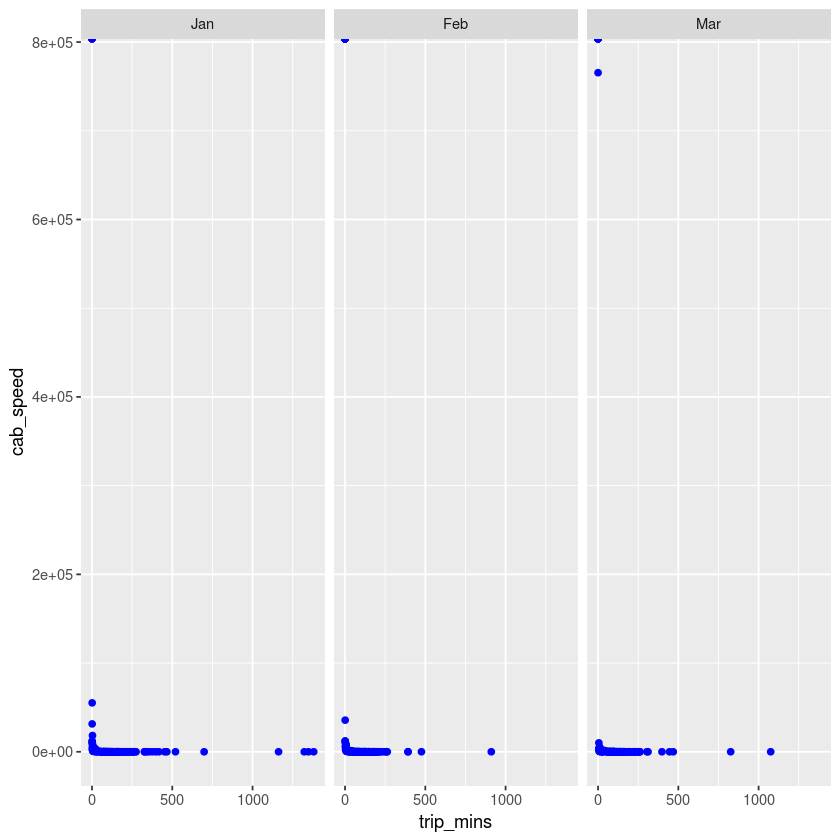

In [106]:

taxi_long_routes <- taxi_long_routes %>% mutate(cab_speed=trip_miles*60*60/trip_seconds)


ggplot(taxi_long_routes, aes(x=trip_mins, y=cab_speed)) +  geom_point(color="blue") + facet_wrap(~ trip_start_month)



##### Clearly we have some cabs with speeds of more than 20,000 miles per hour! 


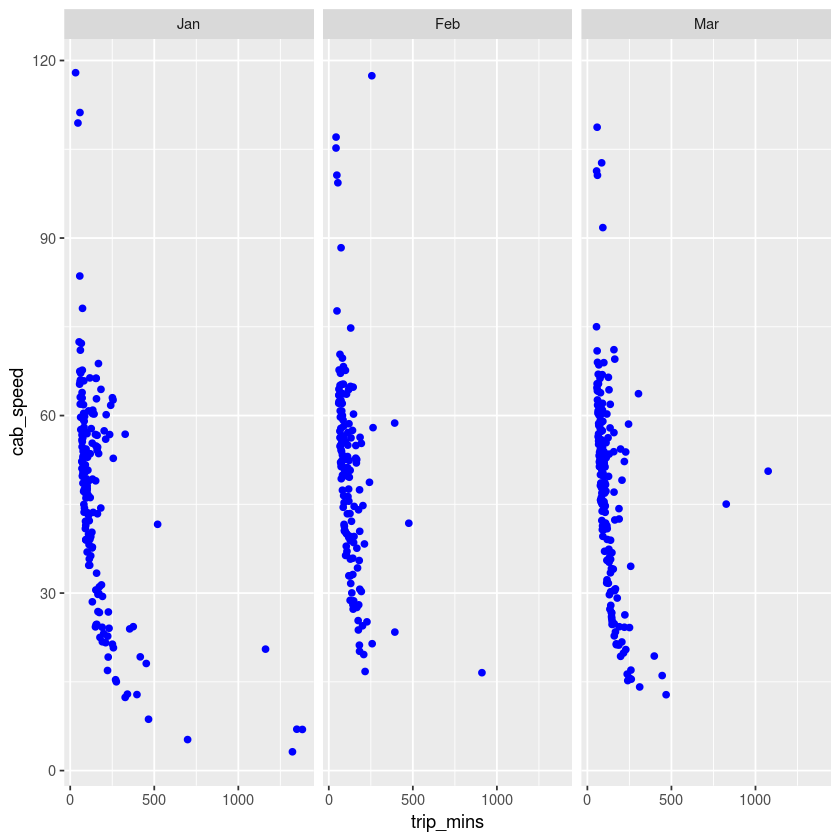

In [107]:

taxi_long_routes_filtered_by_speed <- taxi_long_routes %>% filter(cab_speed < 120)
ggplot(taxi_long_routes_filtered_by_speed, aes(x=trip_mins, y=cab_speed)) +  geom_point(color="blue") + facet_wrap(~ trip_start_month)


#### Let's see the number of longer routes rides increases or not


In [27]:
taxi_long_routes_filtered_by_speed_month <- taxi_long_routes_filtered_by_speed %>% group_by(trip_start_month) %>% summarize(no_trips=n())
head(taxi_long_routes_filtered_by_speed_month)

trip_start_month,no_trips
<ord>,<int>
Jan,170
Feb,148
Mar,192


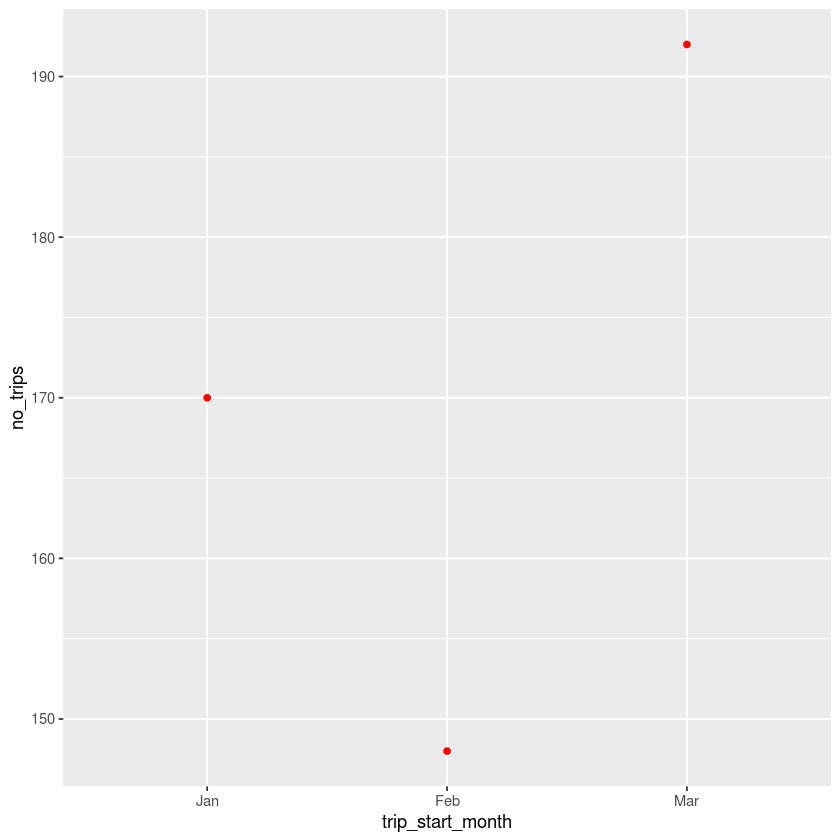

In [108]:
ggplot(taxi_long_routes_filtered_by_speed_month, aes(x=trip_start_month,y=no_trips)) + geom_point(color="red")


#### Observation
- We need more data to make a conculustion. Given we had some invalid data points and maximum no of trips were made in the year 2013. We see a decreasing trend

###  Trends of number rides per week 


trip_start_year,trip_start_week,trips
<dbl>,<chr>,<int>
2017,00,58388
2017,01,407947
2017,02,477824
2017,03,444148
2017,04,455148
2017,05,456192


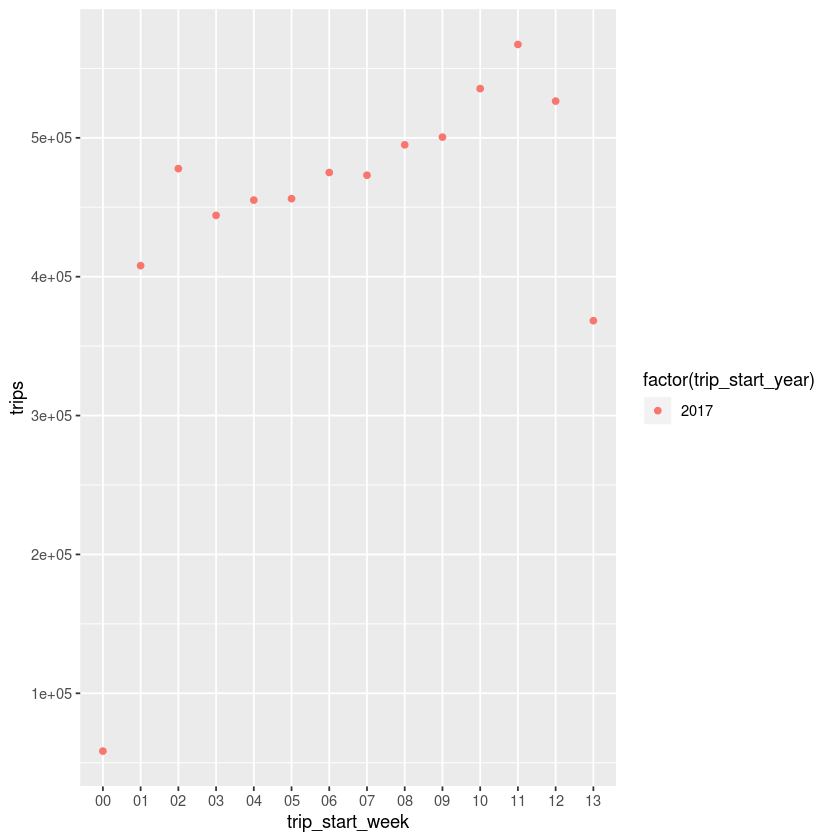

In [37]:
taxi_peak_number_of_rides_per_day_trend <- 
    taxi %>% group_by(trip_start_year, trip_start_week) %>% summarize(trips =n())
head(taxi_peak_number_of_rides_per_day_trend)
ggplot(taxi_peak_number_of_rides_per_day_trend, aes(x=trip_start_week, y=trips, color=factor(trip_start_year))) +  geom_point()


### Moving (Weekly) Average earnings of taxi drivers per month across years



In [52]:
# Load data from big query or disk 
monthly_earning_drivers_csv_path <- './dataset/monthly_earning_drivers.csv'
monthly_earning_drivers <- NULL
if(!file.exists(monthly_earning_drivers_csv_path)){
    monthly_earning_drivers_sql = "SELECT 
        FORMAT_TIMESTAMP('%B', `trip_start_timestamp`) AS trip_start_month, FORMAT_TIMESTAMP('%Y', `trip_start_timestamp`) AS trip_start_year , count(*) AS trips, SUM( trip_total) as total_revenue, SUM( trip_miles) AS total_miles, COUNT(DISTINCT taxi_id) AS no_of_drivers
        FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` 
        group by trip_start_year, trip_start_month order by trip_start_year ASC, trip_start_month ASC"

    monthly_earning_drivers_table <- bq_project_query(projectID,monthly_earning_drivers_sql)
    monthly_earning_drivers <- as.data.frame(bq_table_download(monthly_earning_drivers_table))
# store data
    write.csv(monthly_earning_drivers, monthly_earning_drivers_csv_path)
} else{
    monthly_earning_drivers <- fread(monthly_earning_drivers_csv_path)
}

In [55]:
# calculate average monthly revenue 
monthly_earning_drivers <- monthly_earning_drivers %>% mutate(average_revenue_per_driver=total_revenue/no_of_drivers, average_revenue_per_trip=total_revenue/trips)

# View Data
head(monthly_earning_drivers)

V1,trip_start_month,trip_start_year,trips,total_revenue,total_miles,no_of_drivers,average_revenue_per_driver,average_revenue_per_trip
<int>,<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,April,2013,2116671,32309166,5182258,4390,7359.719,15.26414
2,August,2013,2410602,33852298,4380282,4749,7128.300,14.04309
3,December,2013,2647187,35191073,5360859,5403,6513.247,13.29376
4,February,2013,1800402,25427791,5036101,4233,6007.038,14.12340
5,January,2013,1590062,21321185,5233709,3365,6336.162,13.40903
6,July,2013,2302623,33265747,4208708,4596,7237.978,14.44689


#### Let's plot the incomes per month across the years 


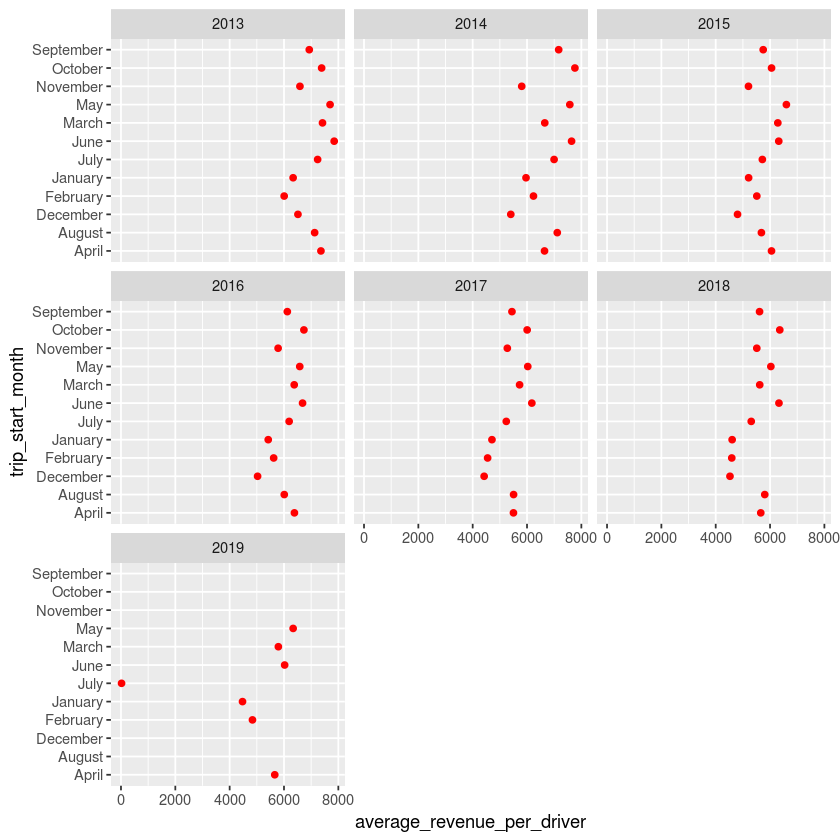

In [70]:
ggplot(monthly_earning_drivers, aes(x=trip_start_month, y=average_revenue_per_driver)) + geom_point(color="red") + facet_wrap(~ trip_start_year) + coord_flip()

#### Observation
- It's intresting that we can see the months of May, June, and October have high average monthly revenues.  Is it because of higher number of trips?


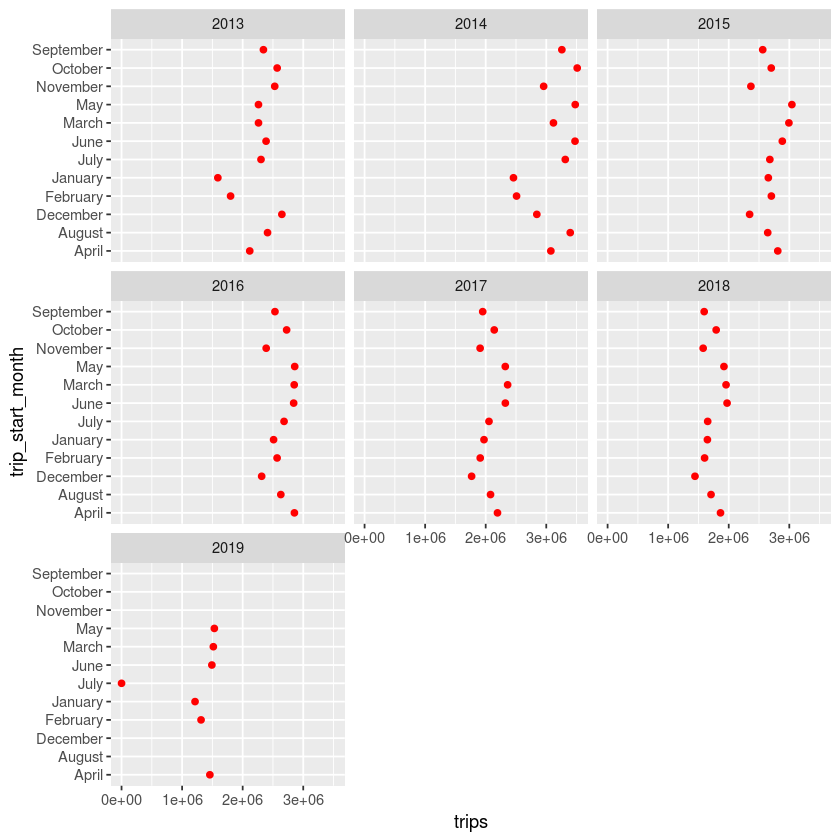

In [71]:
ggplot(monthly_earning_drivers, aes(x=trip_start_month, y=trips)) + geom_point(color="red") + facet_wrap(~ trip_start_year) + coord_flip()

#### By looking at the graphs indeed the months of May, June, and October had higher trips see year 2017, 2018, 2016, 2015, 2014

### Is driving a cab in chicago a luxury job, do we see rise in number of drivers 

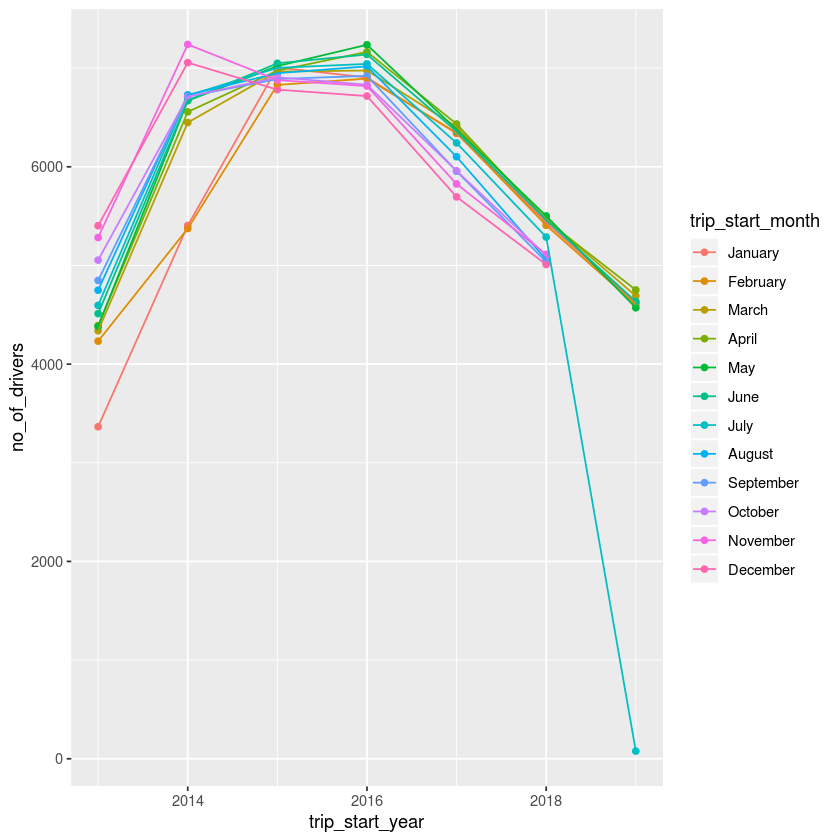

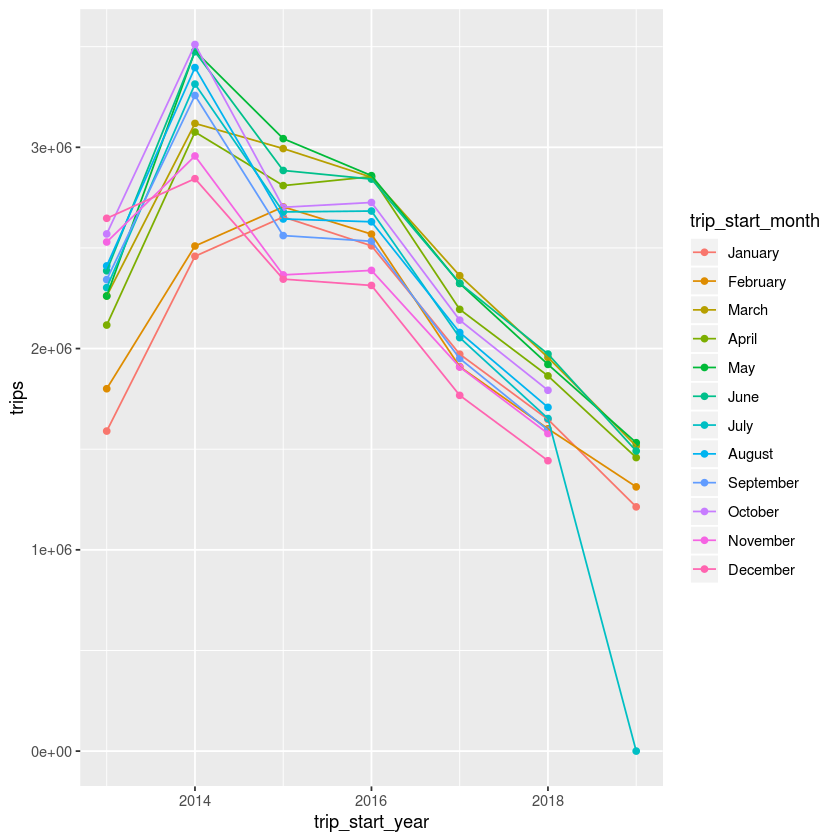

In [83]:
# First let's organize the months 
monthly_earning_drivers <- monthly_earning_drivers %>% mutate(trip_start_month=factor(trip_start_month, levels = month.name)) %>% arrange(trip_start_year, trip_start_month)

ggplot(monthly_earning_drivers, aes(x=trip_start_year, y=no_of_drivers, color=trip_start_month)) + geom_point() + geom_line()

ggplot(monthly_earning_drivers, aes(x=trip_start_year, y=trips, color=trip_start_month)) + geom_point() + geom_line()


#### Monthly Revenue Graph
- Did the decrease in no of trips and drivers affect the average revenue?

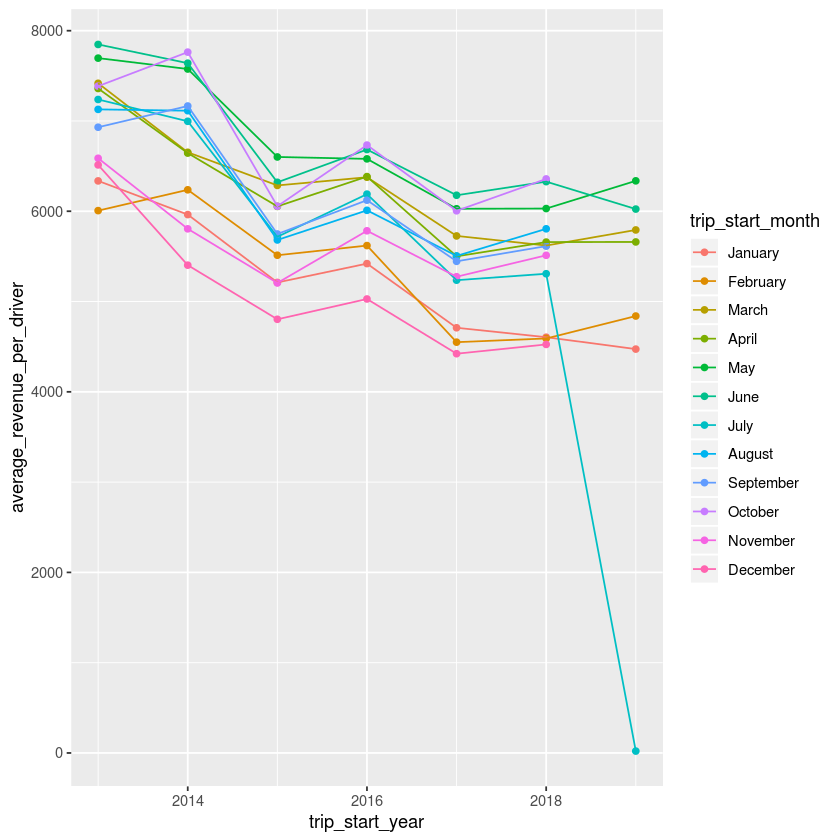

In [84]:
ggplot(monthly_earning_drivers, aes(x=trip_start_year, y=average_revenue_per_driver, color=trip_start_month)) + geom_point() + geom_line()

#### Observation
- There was an increase in number of trips and drivers from 2013 to 2014
- The monthly revenue was also high in the year 2013 and 2014
- We can cleary see a decrease in in numbers of trips and drivers moving forward. 
- This can be a result from competion from companies like Uber and Lyft. 

### Moving forward we will be analyzing the first quarter data (January, February, March) for the year 2014.

The analysis will be focused on answering key performance indicators of drivers 
- Average number of hours worked
- Top performing drivers 
- Drivers availibility (Find missing slots)
- Trip duration vs Gap duration 

For the following analysis we assume all drivers belong to the same parent company. 

#### Imported the public dataset chicago dataset into a a bigquery table 
`SELECT taxi_id, trip_start_timestamp, trip_end_timestamp, trip_seconds, trip_miles, fare, tips, trip_total, payment_type, company  FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` where FORMAT_TIMESTAMP('%m', `trip_start_timestamp`) <= '03' and FORMAT_TIMESTAMP('%Y', `trip_start_timestamp`) = '2014' and trip_seconds > 60 order by `trip_start_timestamp` desc;`

###  Average number of hours worked by drivers per week, average earning per hours per day

#### Load data from Google Big Query

In [143]:
drivers_trips_hours_and_earnings_per_day_sql <- "SELECT taxi_id, FORMAT_TIMESTAMP('%j', trip_start_timestamp) AS trip_start_day,  FORMAT_TIMESTAMP('%W', trip_start_timestamp) AS trip_start_week, SUM(trip_seconds) as total_seconds, SUM(trip_miles) as total_miles, COUNT(*) as trips FROM `logical-bolt-248609.chicago_taxi.chicago_taxi_2014_q1` group by taxi_id, trip_start_week, trip_start_day order by trip_start_day ASC"

drivers_trips_hours_and_earnings_per_day_csv_path <- './dataset/drivers_trips_hours_and_earnings_per_day.csv'
drivers_trips_hours_and_earnings_per_day <- NULL
if(!file.exists(drivers_trips_hours_and_earnings_per_day_csv_path)){

    drivers_trips_hours_and_earnings_per_day_table <- bq_project_query(projectID,drivers_trips_hours_and_earnings_per_day_sql)
    drivers_trips_hours_and_earnings_per_day <- as.data.frame(bq_table_download(drivers_trips_hours_and_earnings_per_day_table))
# store data
    write.csv(drivers_trips_hours_and_earnings_per_day, drivers_trips_hours_and_earnings_per_day_csv_path)
} else{
    drivers_trips_hours_and_earnings_per_day <- fread(drivers_trips_hours_and_earnings_per_day_csv_path)
}


#### View drivers data

In [144]:
head(drivers_trips_hours_and_earnings_per_day)

V1,taxi_id,trip_start_day,trip_start_week,total_seconds,total_miles,trips
<int>,<chr>,<int>,<int>,<int>,<dbl>,<int>
1,29b6866f97b4ee801bebc5fc21758f7092c13f43884c585422cf8227c1ddb10e084a6faa76d65e85885385ae9e7d5579b145b49c83ca839470320a5e998be5ce,1,0,35160,139.2,51
2,6027026bae159d4f0f8f0e3eaab1abeeb1d23f6311fbe98e065d89c06db26ff0d446bd98068fd4d468b6db6418695687015f66dda789c4e62bc9182f837fe66a,1,0,20760,0.0,30
3,f9ccea6ec8d61adb4b8ee9c07f51c1e5b1cd8d023d05329a305d62c6c50c867355487567bf97124e31265274f094311bf23321e3b85833bc06b132914c6bed06,1,0,18984,77.3,27
4,3d5fcccd2f2e4fb12eba0d94f8cdf657b20d405fece7c8a26571a7a0db7d8f8cf4f257a86ad49ad864417c6d8ceb0763b2207fbb57a78950f2566409e1b93fcd,1,0,27840,255.8,34
5,f5337a97915bf0266c525517caa320f251c924c8ece954720c0ff26ef0b9497799e171511560859486ba69d566c5c199db8417011ec1c8fca093ce70dbba554f,1,0,23280,0.0,32
6,abf6ffe94144e712e0efd817d27e8b918121efc45a7e4eba53c63968dad12e0dbc466541eb5ae504956242e437cac686b2754669b5eaadeb3bbdebeb694e8d0f,1,0,34800,183.1,47


Warning message:
“Using size for a discrete variable is not advised.”

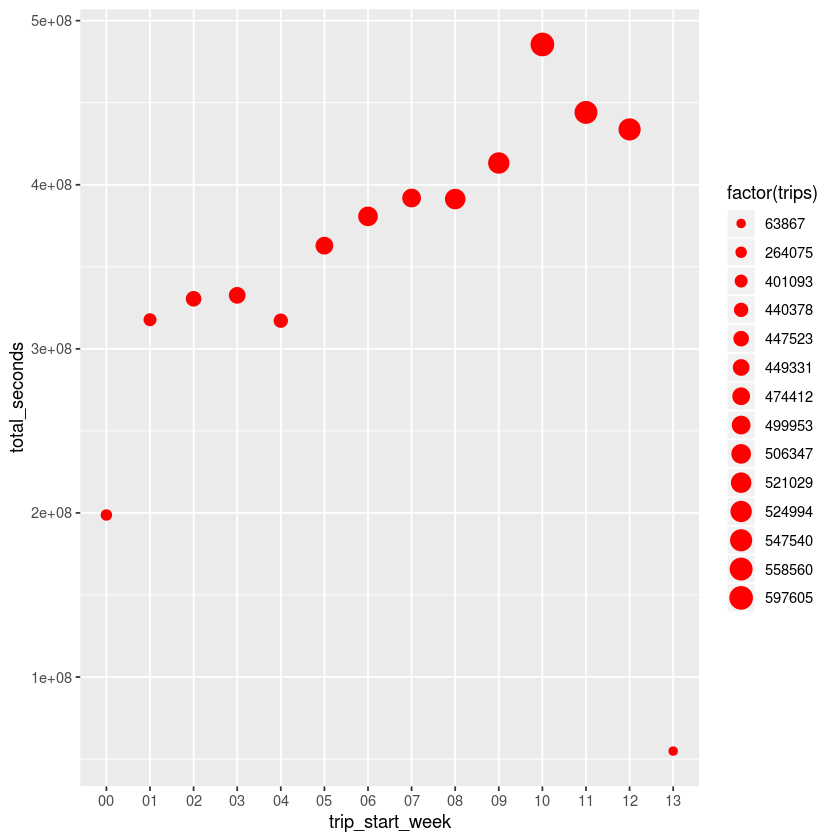

In [96]:
# Remove records with total_miles per day is zero 
drivers_trips_hours_and_earnings_per_day_clean <- drivers_trips_hours_and_earnings_per_day %>% filter(total_miles > 0, trips > 0)

drivers_trips_hours_and_earnings_per_day_clean_group_by_week <- drivers_trips_hours_and_earnings_per_day_clean %>% 
    group_by(trip_start_week) %>% summarize(total_seconds=sum(total_seconds), trips=sum(trips)) 

ggplot(drivers_trips_hours_and_earnings_per_day_clean_group_by_week, aes(x=trip_start_week, y=total_seconds, size=factor(trips))) + geom_point(color="red")



#### Observation
We can see the number of time spent per week increases and this can be justified by higher number of trips

### Is there a correlation between the fare and tip. 


#### Load data from Google Big Query

In [10]:

fare_tip_sql <- "SELECT fare, tips FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips` where fare > 0 and tips > 0 and FORMAT_TIMESTAMP('%Y', trip_start_timestamp) = '2014'"

fare_tip_csv_path <- './dataset/fare_tip.csv'

fare_tip <- NULL
if(!file.exists(fare_tip_csv_path)){

    fare_tip_table <- bq_project_query(projectID,fare_tip_sql)
    fare_tip <- as.data.frame(bq_table_download(fare_tip_table))
# store data
    write.csv(fare_tip, fare_tip_csv_path)
} else{
    fare_tip <- fread(fare_tip_csv_path)
}
head(fare_tip)

fare,tips
<dbl>,<dbl>
9.44,1.00
14.25,3.00
37.25,10.00
30.25,8.06
37.25,9.81
35.25,7.00


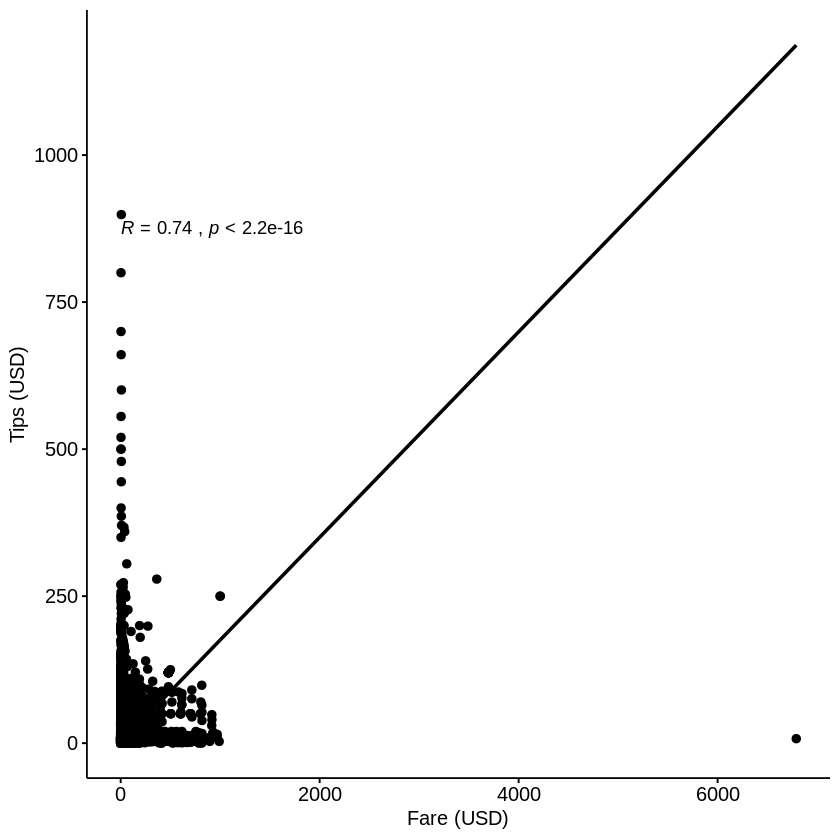

In [11]:
library("ggpubr")
ggscatter(fare_tip, x = "fare", y = "tips", 
          add = "reg.line", conf.int = TRUE, 
          cor.coef = TRUE, cor.method = "pearson",
          xlab = "Fare (USD)", ylab = "Tips (USD)")

#### Observation
The sample data shows a correlation coefficient of 0.74

### Driver/Captain Avaibility Analysis

#### Let's get the drivers schedule first

In [120]:
captian_schedule_sql <- "SELECT taxi_id, 
  week,
  date,
  ROUND(DIV(SUM(trip_seconds),60*60), 1) as hours,
  CASE WHEN COUNTIF(trip_start_hour = '0') > 0 or COUNTIF(trip_end_hour = '0') > 0 THEN 1 ELSE 0 END AS occu_00,
  CASE WHEN COUNTIF(trip_start_hour = '1') > 0 or COUNTIF(trip_end_hour = '1') > 0 THEN 1 ELSE 0 END AS occu_01,
  CASE WHEN COUNTIF(trip_start_hour = '2') > 0 or COUNTIF(trip_end_hour = '2') > 0 THEN 1 ELSE 0 END AS occu_02,
  CASE WHEN COUNTIF(trip_start_hour = '3') > 0 or COUNTIF(trip_end_hour = '3') > 0 THEN 1 ELSE 0 END AS occu_03,
  CASE WHEN COUNTIF(trip_start_hour = '4') > 0 or COUNTIF(trip_end_hour = '4') > 0 THEN 1 ELSE 0 END AS occu_04,
  CASE WHEN COUNTIF(trip_start_hour = '5') > 0 or COUNTIF(trip_end_hour = '5') > 0 THEN 1 ELSE 0 END AS occu_05,
  CASE WHEN COUNTIF(trip_start_hour = '6') > 0 or COUNTIF(trip_end_hour = '6') > 0 THEN 1 ELSE 0 END AS occu_06,
  CASE WHEN COUNTIF(trip_start_hour = '7') > 0 or COUNTIF(trip_end_hour = '7') > 0 THEN 1 ELSE 0 END AS occu_07,
  CASE WHEN COUNTIF(trip_start_hour = '8') > 0 or COUNTIF(trip_end_hour = '8') > 0 THEN 1 ELSE 0 END AS occu_08,
  CASE WHEN COUNTIF(trip_start_hour = '9') > 0 or COUNTIF(trip_end_hour = '9') > 0 THEN 1 ELSE 0 END AS occu_09,
  CASE WHEN COUNTIF(trip_start_hour = '10') > 0 or COUNTIF(trip_end_hour = '10') > 0 THEN 1 ELSE 0 END AS occu_10,
  CASE WHEN COUNTIF(trip_start_hour = '11') > 0 or COUNTIF(trip_end_hour = '11') > 0 THEN 1 ELSE 0 END AS occu_11,
  CASE WHEN COUNTIF(trip_start_hour = '12') > 0 or COUNTIF(trip_end_hour = '12') > 0 THEN 1 ELSE 0 END AS occu_12,
  CASE WHEN COUNTIF(trip_start_hour = '13') > 0 or COUNTIF(trip_end_hour = '13') > 0 THEN 1 ELSE 0 END AS occu_13,
  CASE WHEN COUNTIF(trip_start_hour = '14') > 0 or COUNTIF(trip_end_hour = '14') > 0 THEN 1 ELSE 0 END AS occu_14,
  CASE WHEN COUNTIF(trip_start_hour = '15') > 0 or COUNTIF(trip_end_hour = '15') > 0 THEN 1 ELSE 0 END AS occu_15,
  CASE WHEN COUNTIF(trip_start_hour = '16') > 0 or COUNTIF(trip_end_hour = '16') > 0 THEN 1 ELSE 0 END AS occu_16,
  CASE WHEN COUNTIF(trip_start_hour = '17') > 0 or COUNTIF(trip_end_hour = '17') > 0 THEN 1 ELSE 0 END AS occu_17,
  CASE WHEN COUNTIF(trip_start_hour = '18') > 0 or COUNTIF(trip_end_hour = '18') > 0 THEN 1 ELSE 0 END AS occu_18,
  CASE WHEN COUNTIF(trip_start_hour = '19') > 0 or COUNTIF(trip_end_hour = '19') > 0 THEN 1 ELSE 0 END AS occu_19,
  CASE WHEN COUNTIF(trip_start_hour = '20') > 0 or COUNTIF(trip_end_hour = '20') > 0 THEN 1 ELSE 0 END AS occu_20,
  CASE WHEN COUNTIF(trip_start_hour = '12') > 0 or COUNTIF(trip_end_hour = '21') > 0 THEN 1 ELSE 0 END AS occu_21,
  CASE WHEN COUNTIF(trip_start_hour = '22') > 0 or COUNTIF(trip_end_hour = '22') > 0 THEN 1 ELSE 0 END AS occu_22,
  CASE WHEN COUNTIF(trip_start_hour = '23') > 0 or COUNTIF(trip_end_hour = '23') > 0 THEN 1 ELSE 0 END AS occu_23,
  COUNT(*) as trips
  FROM(
  SELECT taxi_id, 
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        trip_total,
        payment_type,
        company,
        FORMAT_TIMESTAMP('%W', trip_start_timestamp) as week,
        FORMAT_TIMESTAMP('%F', trip_start_timestamp) as date,
        FORMAT_TIMESTAMP('%H', trip_start_timestamp) as trip_start_hour,
        FORMAT_TIMESTAMP('%H', TIMESTAMP_ADD( trip_start_timestamp, INTERVAL trip_seconds SECOND)) as trip_end_hour
        FROM `logical-bolt-248609.chicago_taxi.chicago_taxi_2014_q1`) AS tbl
        group by taxi_id, week, date
        order by week, date"

captian_schedule_csv_path <- './dataset/captian_schedule_2014_Q1.csv'

captian_schedule <- NULL
if(!file.exists(captian_schedule_csv_path)){

    captian_schedule_table <- bq_project_query(projectID,captian_schedule_sql)
    captian_schedule <- as.data.frame(bq_table_download(captian_schedule_table))
# store data
    write.csv(captian_schedule, captian_schedule_csv_path)
} else{
    captian_schedule <- fread(captian_schedule_csv_path)
}


#### The schedule for each driver/captain display the first 5 rows

In [118]:
head(captian_schedule)

taxi_id,week,date,hours,occu_00,occu_01,occu_02,occu_03,occu_04,occu_05,⋯,occu_15,occu_16,occu_17,occu_18,occu_19,occu_20,occu_21,occu_22,occu_23,trips
<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
f9ccea6ec8d61adb4b8ee9c07f51c1e5b1cd8d023d05329a305d62c6c50c867355487567bf97124e31265274f094311bf23321e3b85833bc06b132914c6bed06,00,2014-01-01,5,0,0,0,0,0,0,⋯,0,0,1,1,1,1,1,1,1,27
25d14a6b429ecc54f2b698138ad74b351829a70fdff7887ba12ecf5597880f9c7aa6b097306b088316356779cf11b0a1533ee4c74e1024ec96aa338bf7bfa3f0,00,2014-01-01,4,0,0,0,0,0,0,⋯,1,1,1,1,1,1,1,0,1,24
67cbad0de729d814d848a331b1e37cb8df3a5537fc7d879eb2d2ea32d4295d5fc56bb273eaaba13f85d1cfcff73b295c598e03af1c54660ec0f0db8e8bd69759,00,2014-01-01,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,3
22afb4771955cd3fe6dd9af4e301617761ff2e13312ec5642f1dfd4bdced33dff1644c53596185cf6d021eb7513c195448e9ccff8a91a66b296f2ed236e4e53f,00,2014-01-01,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,1,1,5
10e8a565ac8829bd9caa44f57e9831fd8b4ff374e4d6667337dc4114eb4a0356ec563e55a82e248e315ebf8e938ed4c8418dda95d5a5b409e7ce9b6139215b24,00,2014-01-01,0,0,0,0,0,0,0,⋯,0,0,1,1,0,0,0,0,1,4
951a3a506449095aee566d3ea802cb740a98146569b6fccd89accfd92ee39d08e38b4eb3abcde533f05ca676d5a4a68fc66a708b8884bcfcedabdc18b3495d27,00,2014-01-01,4,0,0,0,0,0,0,⋯,1,1,1,1,1,0,0,1,1,13


#### Top 10 Performing Drivers this Quarter (Based on number of trips)

In [142]:
captian_schedule_top_10_performers <- captian_schedule %>% group_by(taxi_id) %>% summarize(trips=sum(trips), hours=sum(hours)) %>% arrange(desc(trips))
head(captian_schedule_top_10_performers, n=10)

taxi_id,trips,hours
<chr>,<int>,<int>
774c16d2c0c72290e3a9071249c0aabbc14ac4400b200873cacd798a6110bb5babc92b24b84dd27f33de4a30e6af8f554123a2834ac10c5a3fc056cd93d84259,4980,809
1e4ba7f6a2c79ac2220073aa7006dd757feed6b12d4a402b0c803a964fe73104cdbebf1f9062017e384c3fce45f7b118ebe2d3a85c91f2345a9ff5f88b7921a3,4231,618
4bb55b69e710d1792f5fd4888001f4ff0ce34040f976f8dd0307a1b5846f9a5f8855d2ab73ede4ba5167f8101c22dba1ff68f2a6d8a402ebafca9cbab923f694,4169,804
f737a9a31b07650672910268d7cceb9c06a379c0e75070c0dc0366db8132b06ba2800c5e63c5e56f821a591fc78a92c1c60fb5f48e01aa02e62ff10d18ececd0,3872,692
01fea6dd04ff9ae6c26502b2742bb6d4e06be62d2c009526a3edf02aafeef9a1896341f4f6440e8b4b3889dc1b587f6c99581e22bcac650ecd73e88afedc2341,3832,615
99ab5248605aa4afb82e6be7d50d531fd8e423980159bbfb10d05e9d025522bde4b6b357da53e9a809fa24398085b539ee5e1d6408872264b9dbb9c9e7b4c6d0,3716,625
78577da1f3a925bb4133a9b773f5998cec07219c6112dc785aea4a7cc2d08c4e698ef687a64ef2c2401678ad0a9337ce1faeb9e7e74dea25d08f61b610637dc9,3668,587
0a89c89d2e743b2f137de7f7a068a45ec486cef6dba0d4c3b193dc28a31a0c91fb318379ce720f6c0be9af2bc93d148009a5011f2cbea1133077f65a8507f283,3661,779
9b48ad5744e86450fb4db78e7095a6827bafc43a6a9d9a8f656aac46cc0e429d129471cdad31f8a5a97b3a45c8af5fcbc80d003c1c4839075733900786e1a5a9,3651,687


In [122]:
captian_schedule_hm <- captian_schedule %>% select(-c(taxi_id,week,date, hours, V1,trips)) %>%
  rownames_to_column() %>%
  gather(colname, value, -rowname)
captian_schedule_hm_day <-captian_schedule_hm %>% mutate(
    date=as.Date(captian_schedule$date[as.numeric(rowname)]),
    colname=factor(colname)
    ) %>%
    group_by(date,colname)  %>% summarize(value=mean(value)) %>% arrange(date,colname)

#### View Data for Captain Schedule after tranformations


In [123]:
head(captian_schedule_hm)

rowname,colname,value
<chr>,<chr>,<int>
1,occu_00,0
2,occu_00,0
3,occu_00,0
4,occu_00,0
5,occu_00,0
6,occu_00,0


#### Let's visualize their schedules through a heatmap

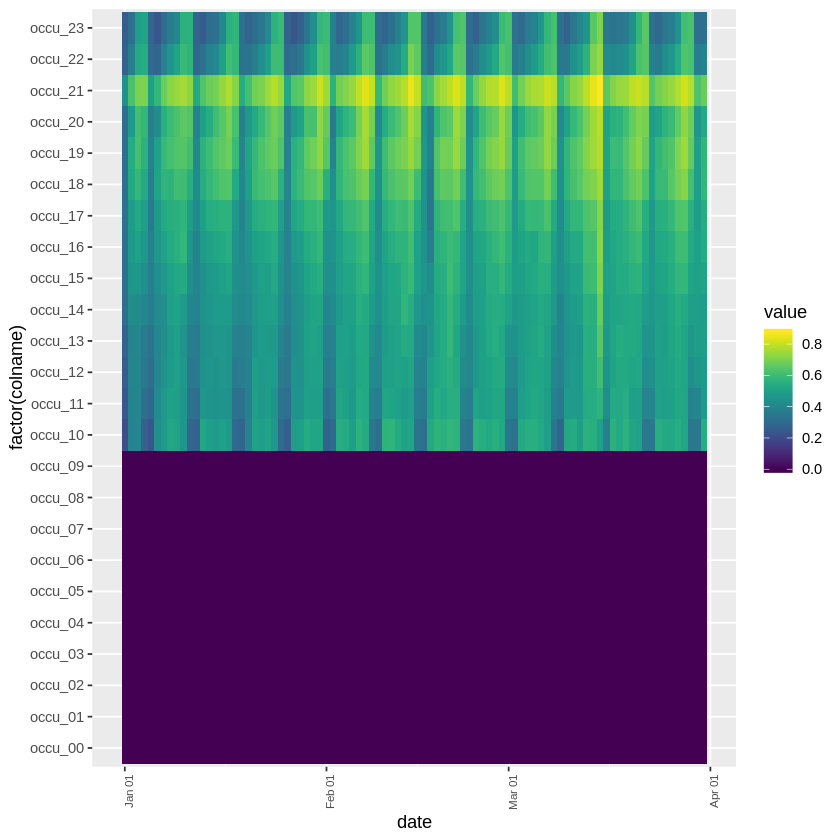

In [124]:
ggplot(captian_schedule_hm_day, aes(x = date, y = factor(colname), fill = value)) +
  geom_tile() +  theme(axis.text.x = element_text(angle=90, hjust = 1, size=7)) +
    scale_x_date(date_labels = "%b %d") + 
    scale_color_viridis(discrete = FALSE, option = "D") +
    scale_fill_viridis(discrete = FALSE) 

#### The heatmap shows drivers occupancy is about 60% with majority from 9 am to 11 am. Since we are counting weekdays and weekends, let's break it down furthur. 

#### Let's remove also the occupancy slots with zero values


In [125]:
captian_schedule_hm_week <- captian_schedule_hm %>% mutate(
    week=as.numeric(captian_schedule$week[as.numeric(rowname)]),
    month=month(captian_schedule$date[as.numeric(rowname)], TRUE),
    colname=factor(colname)
    ) %>%
    group_by(month,week,colname)  %>% summarize(value=mean(value)) %>% arrange(month,week,colname) 

captian_schedule_hm_week <- captian_schedule_hm_week %>% filter(value > 0)

#### VIew Data

In [128]:
head(captian_schedule_hm_week, n=1)

month,week,colname,value
<ord>,<dbl>,<fct>,<dbl>
Jan,0,occu_10,0.3005899


#### Visualize the heatmap based on weeks on a monthly basis

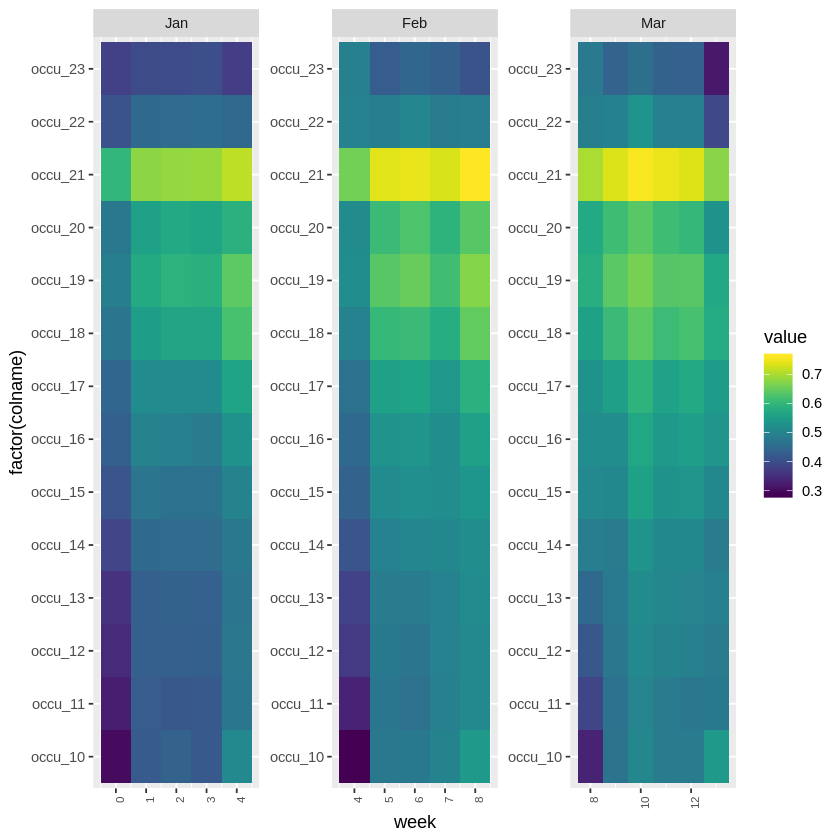

In [130]:
ggplot(captian_schedule_hm_week, aes(x = week, y = factor(colname), fill = value)) +
  geom_tile() +  theme(axis.text.x = element_text(angle=90, hjust = 1, size=7)) +
    scale_color_viridis(discrete = FALSE, option = "D") +
    scale_fill_viridis(discrete = FALSE) + facet_wrap(~ month, scale="free")
    

#### Observations 
- The first month of quater starts gradually with low occupacny. In fact first week of very month the occupancy is low.
- 9:00 P.M is the busiest hour with high occupancy 

#### Let's break it down furthur to see on a weekly basis. This will also gives us some insights on weekdays vs weekends trips.

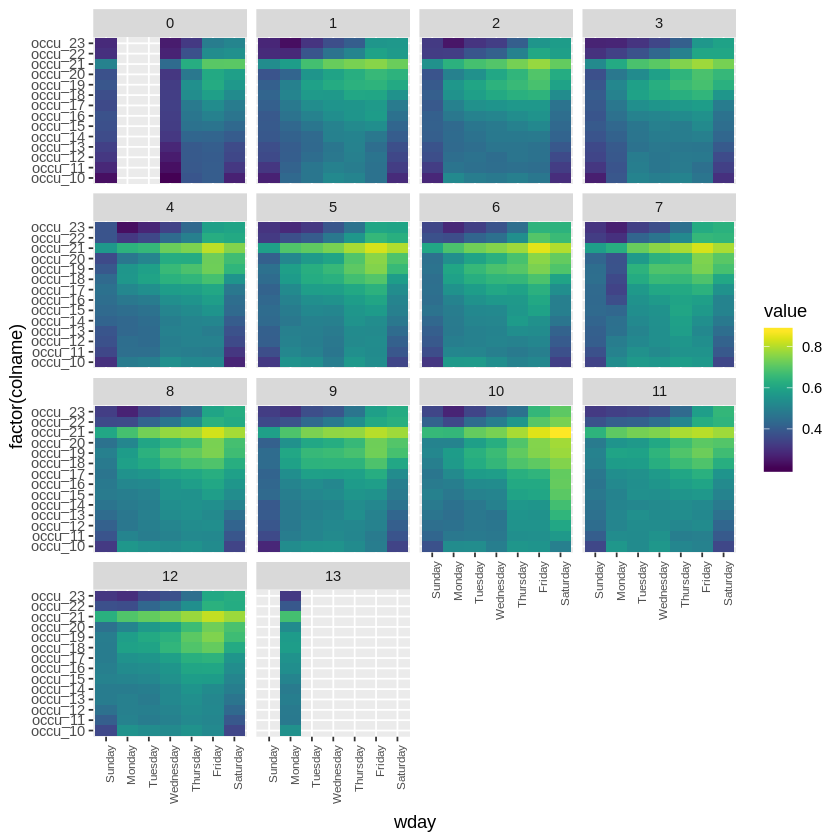

In [131]:
captian_schedule_hm_wday <- captian_schedule_hm %>% mutate(
    week=as.numeric(captian_schedule$week[as.numeric(rowname)]),
    wday=wday(captian_schedule$date[as.numeric(rowname)], label=TRUE, abbr=FALSE, locale = Sys.getlocale("LC_TIME")),
    colname=factor(colname)
    ) %>%
    group_by(week,wday,colname)  %>% summarize(value=mean(value)) %>% arrange(week,colname) 

captian_schedule_hm_wday <- captian_schedule_hm_wday %>% filter(value > 0)

# Plot 
ggplot(captian_schedule_hm_wday, aes(x = wday, y = factor(colname), fill = value)) +
  geom_tile() +  theme(axis.text.x = element_text(angle=90, hjust = 1, size=7)) +
    scale_color_viridis(discrete = FALSE, option = "D") +
    scale_fill_viridis(discrete = FALSE) + facet_wrap(~ week)
    

### Observations
- Saturdays & Sundays is a weekend in Chicago
- Looking through week 0 - 9 and 11 - 12. We can see the occupancy decreases on weekends. 
- The highest occupancy is at 9 P.M every Friday. 
- The number of trips at night are much less. Based from previous analysis peak time of rides are from 3 PM to 8 PM. 
- However, night times have fewer trips but longer durations



### Conclusion & Future Work

#### Conclusion

- The most busiest areas in chicago are where the parks & museum's placed
- Looking at the peak times in Chihcago City it's from 3 PM to 8PM. This shows the city sleeps early, stores closes around between 7 PM to 8PM.
- We can see a trend of decrease in number of drivers, trips, and average revenue. This shows that a decrease in Chicago taxis cabs could be due to competition. 
- We also see a correlation between fare and trip. 
- Chicago cab drivers used to make 8000 USD/month in 2013 to 6000 USD/month in 2017.
- Top perfoming drivers
- Drivers avalibility schedule 
- Weekdays and weekends trips 

#### Future Work
- Find a suitable time to to park avoiding rush hours
